In [1]:
import os
import glob as glob
import matplotlib.pyplot as plt
import cv2
import random
import numpy as np

from torchvision import models

np.random.seed(42)

### Download dataset from Roboflow

In [ ]:
if not os.path.exists('train'):
    !curl -L "https://app.roboflow.com/ds/WzTqJkwwds?key=jLlq9hXqBg" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   901  100   901    0     0   1479      0 --:--:-- --:--:-- --:--:--  1479
100 4479k  100 4479k    0     0  2090k      0  0:00:02  0:00:02 --:--:-- 3663k
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
 extracting: data.yaml               
   creating: test/
   creating: test/images/
 extracting: test/images/Ayah-Aldo-009_jpg.rf.fd67e3cdd34a3d6c9d8342190f50ef2c.jpg  
 extracting: test/images/Halo-Aldo-007_jpg.rf.5891ee7105d30f1a27c7e9355eb492d3.jpg  
 extracting: test/images/Kakak-Aldo-001_jpg.rf.98904eab6b45e0c8c0c9f758cca0a985.jpg  
 extracting: test/images/Kakak-Aldo-003_jpg.rf.0bcbbb997185ff963a526bdc49a0cba9.jpg  
 extracting: test/images/Kakak-Aldo-006_jpg.rf.2a90be28a6a798c4ba5fd23d63104601.jpg  
 extracting: test/images/Kakak-Aldo-008_jpg.rf.a73d5f7bf037c32d6ca1d46f966

### Check Structure Model for change the YOLOv5 Backbone to MobileNetv3s

In [4]:
model = models.mobilenet_v3_small()
modules = list(model.children())
modules

[Sequential(
   (0): Conv2dNormActivation(
     (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
     (2): Hardswish()
   )
   (1): InvertedResidual(
     (block): Sequential(
       (0): Conv2dNormActivation(
         (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
         (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
         (2): ReLU(inplace=True)
       )
       (1): SqueezeExcitation(
         (avgpool): AdaptiveAvgPool2d(output_size=1)
         (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
         (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
         (activation): ReLU()
         (scale_activation): Hardsigmoid()
       )
       (2): Conv2dNormActivation(
         (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (1): BatchN

### Clone YOLOv5 after modified the backbone

In [5]:
!git clone https://github.com/hardiantots/yolov5_addBackbone.git

Cloning into 'yolov5_addBackbone'...
remote: Enumerating objects: 170, done.
remote: Counting objects: 100% (170/170), done.
remote: Compressing objects: 100% (131/131), done.
remote: Total 170 (delta 43), reused 161 (delta 38), pack-reused 0
Receiving objects: 100% (170/170), 945.52 KiB | 7.06 MiB/s, done.
Resolving deltas: 100% (43/43), done.


In [6]:
%cd yolov5_addBackbone/
!pwd

/content/yolov5_addBackbone
/content/yolov5_addBackbone


In [7]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.2 MB/s eta 0:00:00


In [ ]:
TRAIN = True
def set_res_dir():
    # Directory to store results
    res_dir_count = len(glob.glob('runs/train/*'))
    print(f"Current number of result directories: {res_dir_count}")
    if TRAIN:
        RES_DIR = f"results_{res_dir_count+1}"
        print(RES_DIR)
    else:
        RES_DIR = f"results_{res_dir_count}"
    return RES_DIR

### Tensorboard

In [ ]:
def monitor_tensorboard():
    %load_ext tensorboard
    %tensorboard --logdir runs/train

In [ ]:
monitor_tensorboard()

### Start training data

In [ ]:
RES_DIR = set_res_dir()

if TRAIN:
    !python train.py --data ../data.yaml --weights yolov5l.pt \
    --img 256 --epochs 200 --batch-size 32 --name {RES_DIR}\
    --cache ram --cache disk \
    --hyp data/hyps/hyp.scratch-low.yaml \
    --cfg models/yoloMobileNetv3s.yaml

### Define Function to show the results of train model

In [ ]:
def show_valid_results(RES_DIR):
    !ls runs/train/{RES_DIR}
    EXP_PATH = f"runs/train/{RES_DIR}"
    validation_pred_images = glob.glob(f"{EXP_PATH}/*_pred.jpg")
    print(validation_pred_images)
    for pred_image in validation_pred_images:
        image = cv2.imread(pred_image)
        plt.figure(figsize=(17, 13))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.show()

In [ ]:
def inference(RES_DIR, data_path):
    # Directory to store inference results.
    infer_dir_count = len(glob.glob('runs/detect/*'))
    print(f"Current number of inference detection directories: {infer_dir_count}")
    INFER_DIR = f"inference_{infer_dir_count+1}"
    print(INFER_DIR)
    # Inference on images.
    !python detect.py --weights runs/train/{RES_DIR}/weights/best.pt \
    --source {data_path} --name {INFER_DIR} --img 256 --conf 0.5
    return INFER_DIR

In [ ]:
def inference_notraining(data_path):
    # Directory to store inference results.
    # infer_dir_count = len(glob.glob('runs/detect/*'))
    # print(f"Current number of inference detection directories: {infer_dir_count}")
    INFER_DIR = f"inference_notraining"
    # print(INFER_DIR)
    # Inference on images.
    !python detect.py --weights models/mobilenetv3s.pt \
    --source {data_path} --name {INFER_DIR} --img 256 --conf 0.5
    return INFER_DIR

In [ ]:
def visualize_jpg(INFER_DIR):
# Visualize inference images.
    INFER_PATH = f"runs/detect/{INFER_DIR}"
    infer_images = glob.glob(f"{INFER_PATH}/*.jpg")
    print(infer_images)
    for pred_image in infer_images:
        image = cv2.imread(pred_image)
        plt.figure(figsize=(8, 5))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.show()

Show valid results

confusion_matrix.png				    results.png
events.out.tfevents.1685849533.96514d80ec15.3307.0  train_batch0.jpg
F1_curve.png					    train_batch1.jpg
hyp.yaml					    train_batch2.jpg
labels_correlogram.jpg				    val_batch0_labels.jpg
labels.jpg					    val_batch0_pred.jpg
opt.yaml					    val_batch1_labels.jpg
P_curve.png					    val_batch1_pred.jpg
PR_curve.png					    val_batch2_labels.jpg
R_curve.png					    val_batch2_pred.jpg
results.csv					    weights
['runs/train/results_1/val_batch2_pred.jpg', 'runs/train/results_1/val_batch1_pred.jpg', 'runs/train/results_1/val_batch0_pred.jpg']


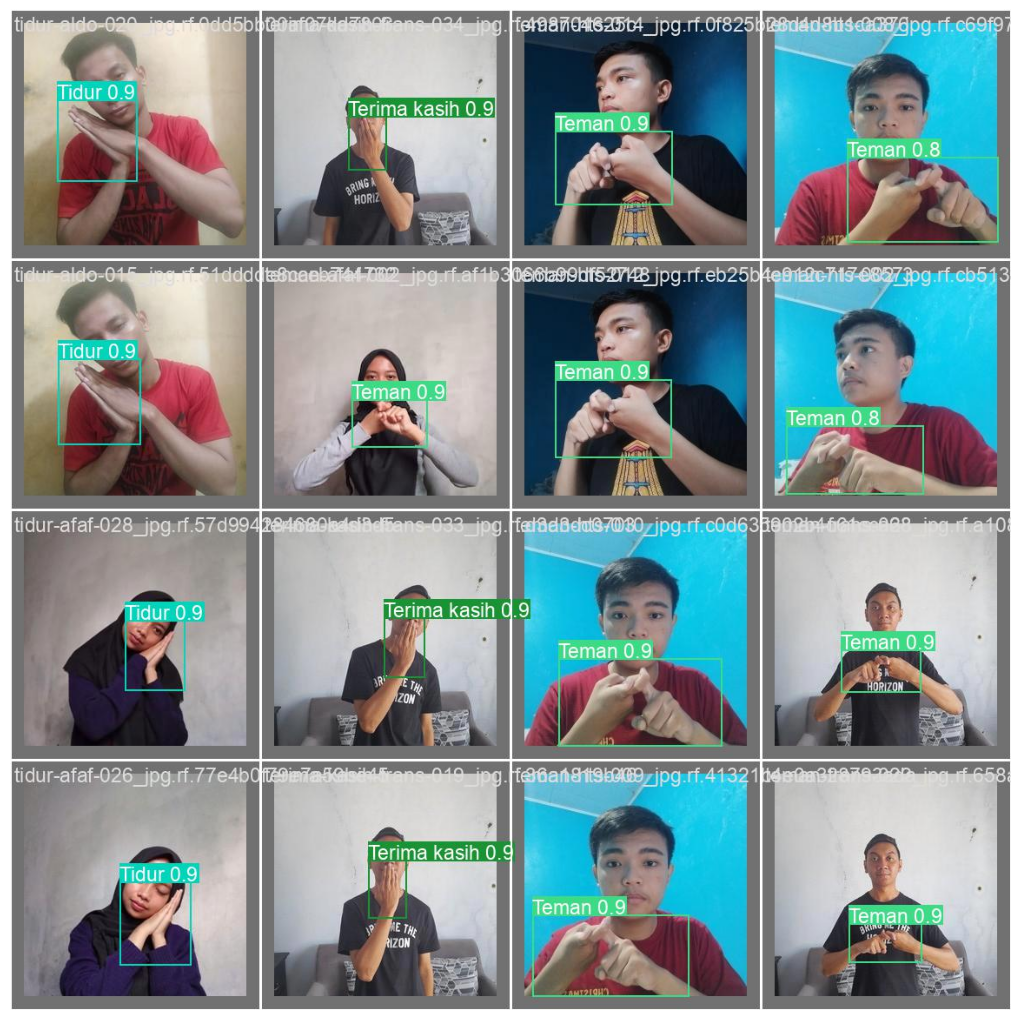

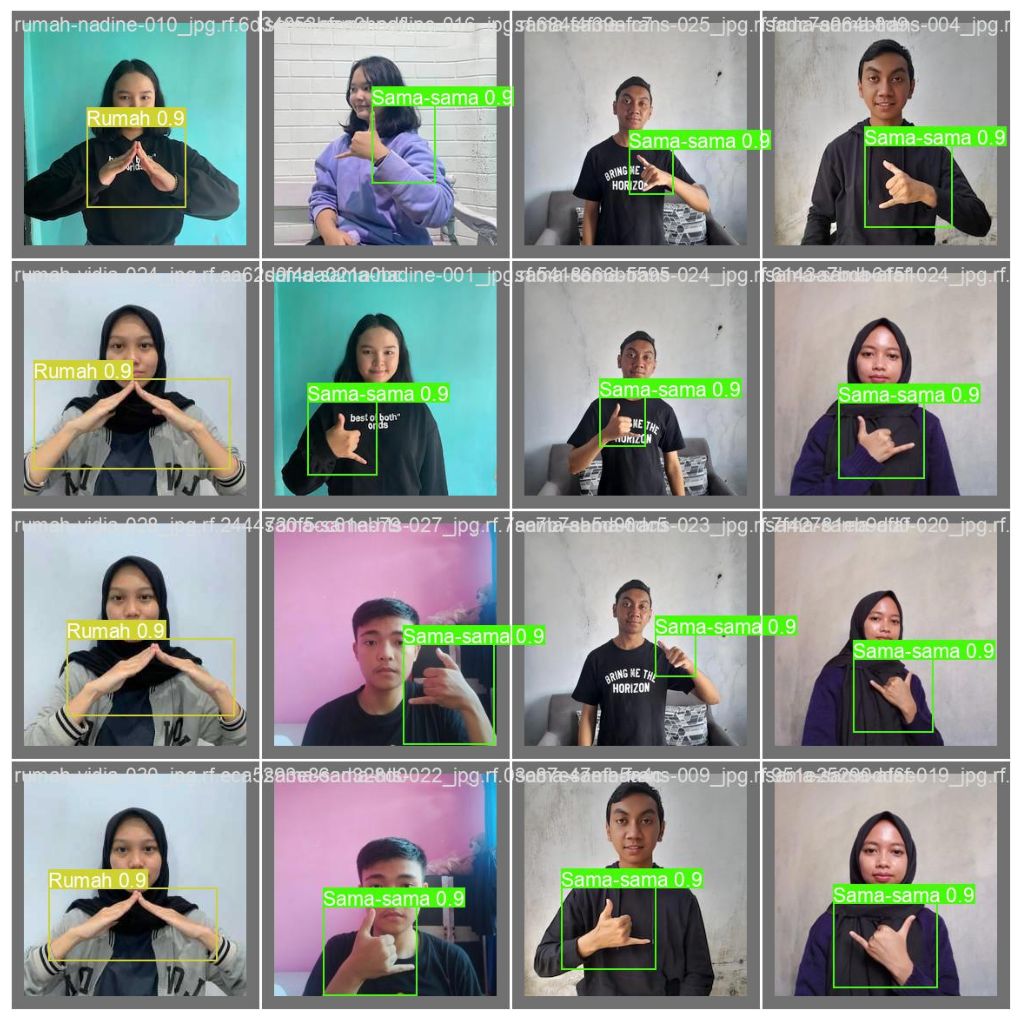

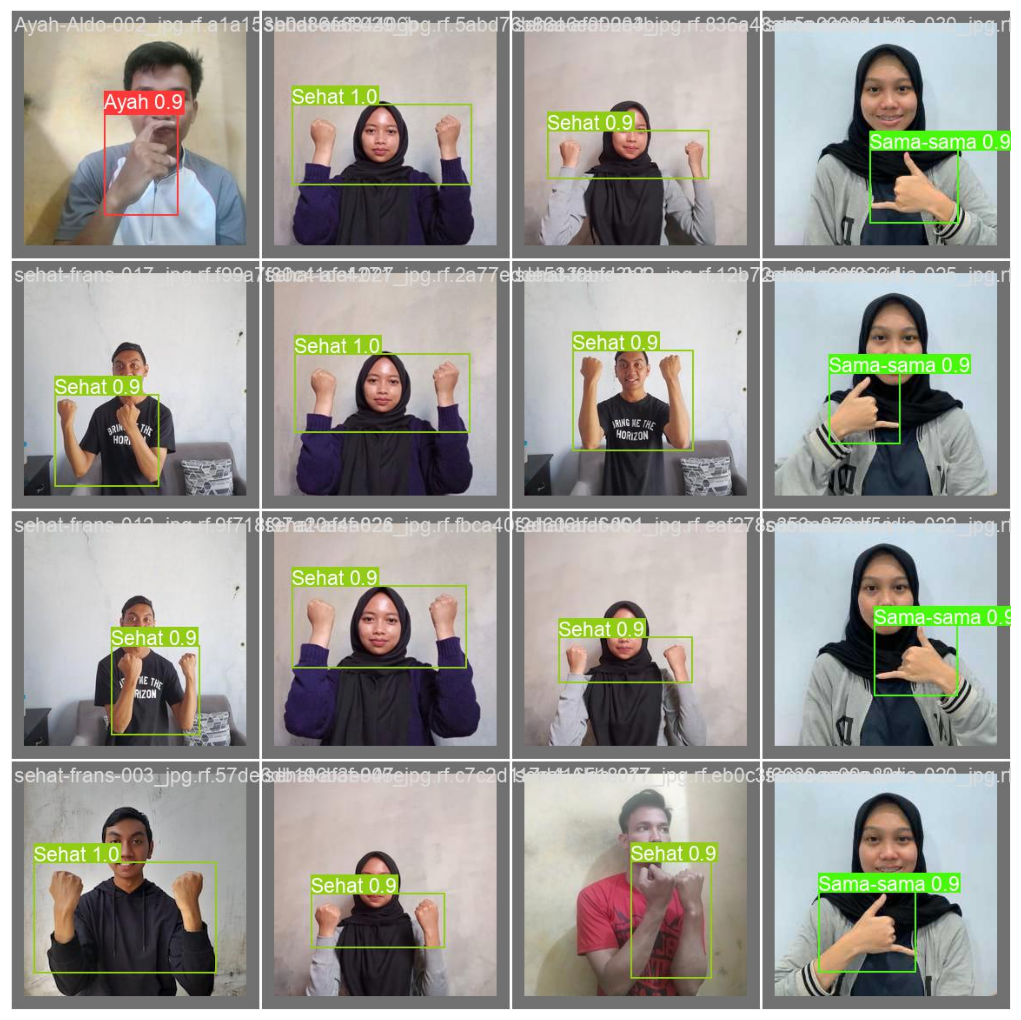

In [ ]:
show_valid_results(RES_DIR)

### Inference Test Images

In [ ]:
if not os.path.exists('bisindo-inference-images'):
    !git clone https://github.com/fransachmadhw/bisindo-inference-images.git

Cloning into 'bisindo-inference-images'...
remote: Enumerating objects: 61, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 61 (delta 12), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (61/61), 935.04 KiB | 17.00 MiB/s, done.


In [ ]:
# Inference on images.
# IMAGE_INFER_DIR = inference(RES_DIR, 'bisindo-inference-images')
IMAGE_INFER_DIR = inference_notraining('bisindo-inference-images')

detect: weights=['models/mobilenetv3s.pt'], source=bisindo-inference-images, data=data/coco128.yaml, imgsz=[256, 256], conf_thres=0.5, iou_thres=0.5, max_det=3, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=inference_notraining, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 125ed53 Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
yoloMobileNetv3s summary: 287 layers, 2145479 parameters, 0 gradients, 3.1 GFLOPs
image 1/10 /content/yolov5_mobilenetv3_streamlit_public/bisindo-inference-images/Annyeong-haseyo.jpg: 192x256 1 Halo, 56.0ms
image 2/10 /content/yolov5_mobilenetv3_streamlit_public/bisindo-inference-images/Sehatno.jpg: 256x256 (no detections), 9.5ms
image 3/10 /content/yolov5_mobilenetv3_streamlit_public/bisindo-inference-images/Teman8

['runs/detect/inference_notraining/rumah80.jpg', 'runs/detect/inference_notraining/Annyeong-haseyo.jpg', 'runs/detect/inference_notraining/cewek-cakep.jpg', 'runs/detect/inference_notraining/ngapain-om.jpg', 'runs/detect/inference_notraining/Trims91.jpg', 'runs/detect/inference_notraining/Sehatno.jpg', 'runs/detect/inference_notraining/jaehyun-tidur69.jpg', 'runs/detect/inference_notraining/om-jangan-om.jpg', 'runs/detect/inference_notraining/pak-jokowi-sedang-berpikir.jpg', 'runs/detect/inference_notraining/Teman87.jpg']


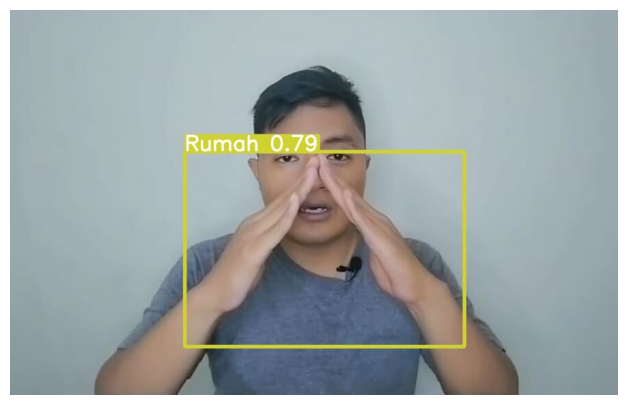

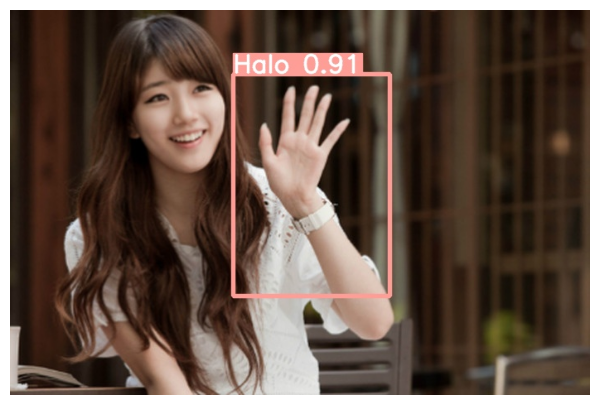

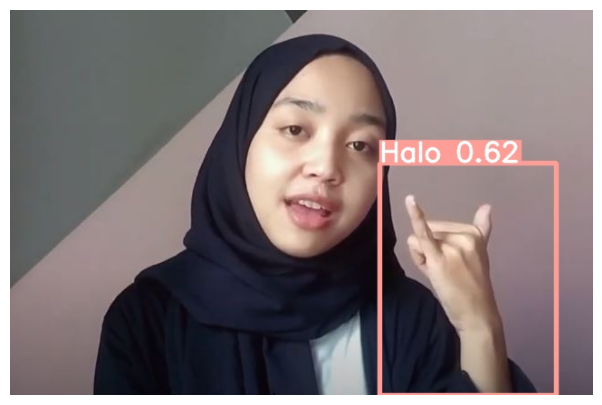

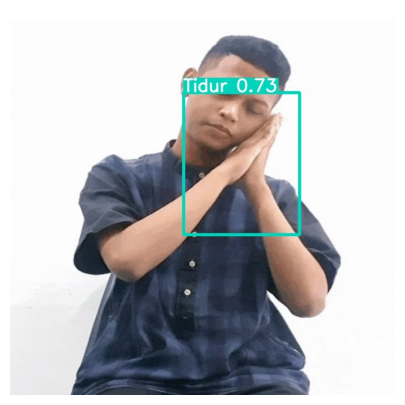

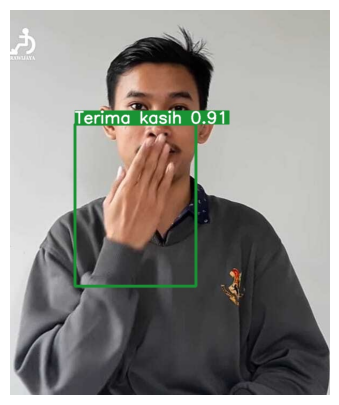

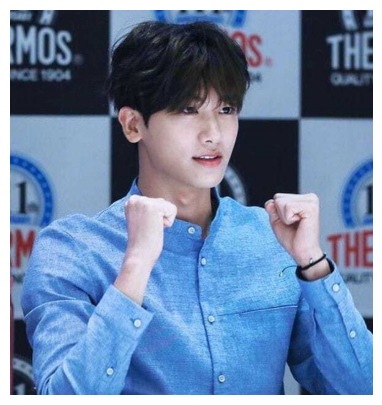

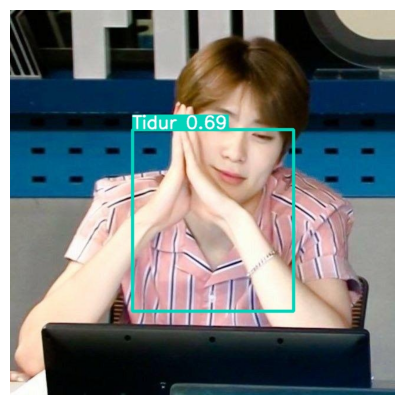

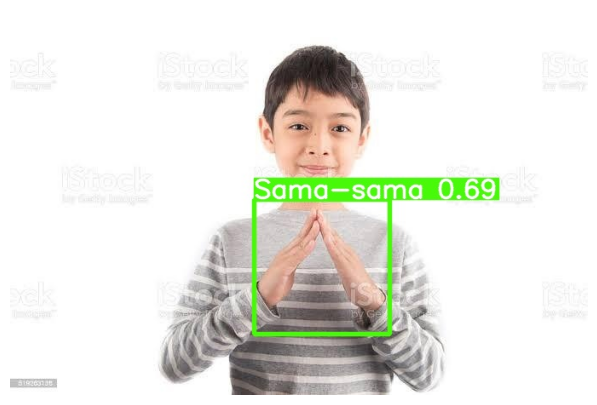

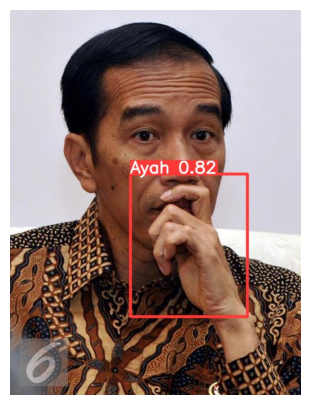

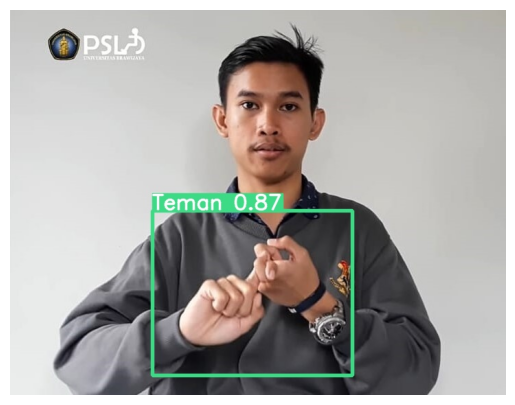

In [ ]:
visualize_jpg(IMAGE_INFER_DIR)